In [1]:
import pandas as pd
from statsbombpy import sb
import numpy as np
from mplsoccer import Pitch,VerticalPitch, Sbopen, FontManager, inset_image
import plotly.express as px
import matplotlib.pyplot as plt

### Setting the dataframe

In [2]:
MATCH_ID = 3869685
match_event_df = sb.events(match_id=MATCH_ID)
match_360_df = pd.read_json(f'/Users/asheshlalshrestha/Desktop/Datanal/Project/Football Data/open-data-master/data/three-sixty/{MATCH_ID}.json')
df = pd.merge(left=match_event_df,right = match_360_df,
              left_on='id',right_on='event_uuid',how='left')

In [3]:
df.head()

50_50 bad_behaviour_card ball_receipt_outcome ball_recovery_offensive  \
0   NaN                NaN                  NaN                     NaN   
1   NaN                NaN                  NaN                     NaN   
2   NaN                NaN                  NaN                     NaN   
3   NaN                NaN                  NaN                     NaN   
4   NaN                NaN                  NaN                     NaN   

  ball_recovery_recovery_failure block_deflection block_offensive  \
0                            NaN              NaN             NaN   
1                            NaN              NaN             NaN   
2                            NaN              NaN             NaN   
3                            NaN              NaN             NaN   
4                            NaN              NaN             NaN   

  carry_end_location clearance_aerial_won clearance_body_part  ...  \
0                NaN                  NaN                 NaN  ...   
1                NaN                  NaN                 NaN  ...   
2                NaN                  NaN                 NaN  ...   
3                NaN                  NaN                 NaN  ...   
4                NaN                  NaN                 NaN  ...   

  substitution_replacement_id  \
0                         NaN   
1                         NaN   
2                         NaN   
3                         NaN   
4                         NaN   

                                             tactics       team team_id  \
0  {'formation': 433, 'lineup': [{'player': {'id'...  Argentina     779   
1  {'formation': 4231, 'lineup': [{'player': {'id...     France     771   
2                                                NaN     France     771   
3                                                NaN  Argentina     779   
4                                                NaN     France     771   

      timestamp         type under_pressure event_uuid visible_area  \
0  00:00:00.000  Starting XI            NaN        NaN          NaN   
1  00:00:00.000  Starting XI            NaN        NaN          NaN   
2  00:00:00.000   Half Start            NaN        NaN          NaN   
3  00:00:00.000   Half Start            NaN        NaN          NaN   
4  00:00:00.000   Half Start            NaN        NaN          NaN   

  freeze_frame  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 97 columns]

### Lets dive deep into the match action types and statistics

In [4]:
## filtering the dataset for france only
df_france_stats = df[df['team']=='France']
## filtering the dataset above

## total passes under 45 mins
total_pass_under_45 = df_france_stats[(df_france_stats['type']=='Pass') & (df_france_stats['minute']<=45)].shape[0]

## total passes over 45 mmins
total_pass_over_45 = df_france_stats[(df['type']=='Pass') & (df['minute']>45)].shape[0]

## total failed passes under 45 mins
tota_failed_under_45 = df_france_stats[
    (df_france_stats['type'] == 'Pass') & 
    (df_france_stats['minute'] <= 45) & 
    (df_france_stats['pass_outcome'].isin(['Out', 'Incomplete']))
].shape[0]

## total failed passes over 45 mins
tota_failed_over_45 = df_france_stats[
    (df_france_stats['type'] == 'Pass') & 
    (df_france_stats['minute'] > 45) & 
    (df_france_stats['pass_outcome'].isin(['Out', 'Incomplete']))
].shape[0]

# Creating a dictionary
data = {'Category': ['Under 45 Mins', 'Over 45 Mins'],
        'Passed': [total_pass_under_45, total_pass_over_45],
        'Failed': [tota_failed_under_45, tota_failed_over_45]}

# Create DataFrame
passes_data = pd.DataFrame(data)

# Melt the DataFrame to long format for Plotly Express
passes_data_long = passes_data.melt(id_vars='Category', var_name='Status', value_name='Count')

fig = px.bar(passes_data_long, x='Category', y='Count', color='Status', barmode='group',
             labels={'Category': 'Pass Categories', 'Count': 'Count'},
             title='Pass Categories Grouped Bar Chart')
fig.show()

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [5]:
df_pass = df_france_stats[['type','location','pass_end_location',
                           'pass_outcome','pass_recipient','pass_type',
                           'play_pattern','player','under_pressure']]
df_pass = df_pass[df_pass['type'] == 'Pass']
pass_played = df_pass.groupby('player').size().reset_index(name='PassPlayed').sort_values(by='PassPlayed',ascending=False)
pass_recieved = df_pass.groupby('pass_recipient').size().reset_index(name='PassRecieved').sort_values(by='PassRecieved',ascending=False)
print(pass_played)
print('------------------------------------------------------------------------')
print(pass_recieved)

                             player  PassPlayed
2         Aurélien Djani Tchouaméni          69
7                      Jules Koundé          67
3          Dayotchanculle Upamecano          64
14                   Raphaël Varane          61
0                     Adrien Rabiot          51
15  Theo Bernard François Hernández          49
5                       Hugo Lloris          41
1                 Antoine Griezmann          30
9              Kylian Mbappé Lottin          27
4                 Eduardo Camavinga          24
10                    Marcus Thuram          22
13                Randal Kolo Muani          15
8                    Kingsley Coman          15
12                  Ousmane Dembélé          13
16                  Youssouf Fofana          11
11                   Olivier Giroud           9
6                   Ibrahima Konaté           2
------------------------------------------------------------------------
                     pass_recipient  PassRecieved
3          Da

### Passes played by Aurélien Djani Tchouaméni
As Tchouaméni is the highest passer

In [6]:
ID=10481.0
## filtering the pass datapoints for Tchouaméni
Tchouaméni_pass = df[(df['player_id']==ID) & (df['type']=='Pass')].reset_index(drop=True)

## setting the x and y start and end points for the passes
Tchouaméni_pass[['x_start','y_start']] = pd.DataFrame(Tchouaméni_pass.location.tolist(),index=Tchouaméni_pass.index)
Tchouaméni_pass[['x_end','y_end']] = pd.DataFrame(Tchouaméni_pass.pass_end_location.tolist(),index=Tchouaméni_pass.index)
## calculating the distances
Tchouaméni_pass['distance'] = np.sqrt((Tchouaméni_pass['x_end'] - Tchouaméni_pass['x_start'])**2 + (Tchouaméni_pass['y_end'] - Tchouaméni_pass['y_start'])**2)
Tchouaméni_pass.head()

50_50 bad_behaviour_card ball_receipt_outcome ball_recovery_offensive  \
0   NaN                NaN                  NaN                     NaN   
1   NaN                NaN                  NaN                     NaN   
2   NaN                NaN                  NaN                     NaN   
3   NaN                NaN                  NaN                     NaN   
4   NaN                NaN                  NaN                     NaN   

  ball_recovery_recovery_failure block_deflection block_offensive  \
0                            NaN              NaN             NaN   
1                            NaN              NaN             NaN   
2                            NaN              NaN             NaN   
3                            NaN              NaN             NaN   
4                            NaN              NaN             NaN   

  carry_end_location clearance_aerial_won clearance_body_part  ...  type  \
0                NaN                  NaN                 NaN  ...  Pass   
1                NaN                  NaN                 NaN  ...  Pass   
2                NaN                  NaN                 NaN  ...  Pass   
3                NaN                  NaN                 NaN  ...  Pass   
4                NaN                  NaN                 NaN  ...  Pass   

  under_pressure                            event_uuid  \
0            NaN  a5956ecc-d637-44d2-8705-e2079e12013e   
1            NaN                                   NaN   
2           True                                   NaN   
3           True  324a4fa4-12a8-4589-beeb-081d171ce841   
4            NaN  3e734ca7-6264-469e-8069-1a188f5bdc83   

                                        visible_area  \
0  [10.227276315524, 80.0, 41.5155332886657, 0.0,...   
1                                                NaN   
2                                                NaN   
3  [22.7413784491641, 80.0, 44.4048044348883, 0.0...   
4  [16.8111045662512, 80.0, 44.4499428657201, 0.0...   

                                        freeze_frame x_start y_start x_end  \
0  [{'teammate': True, 'actor': False, 'keeper': ...    49.7    43.6  96.0   
1                                                NaN    43.9    51.3  66.8   
2                                                NaN    63.8    13.0  61.0   
3  [{'teammate': True, 'actor': False, 'keeper': ...    50.9    26.0  46.0   
4  [{'teammate': True, 'actor': False, 'keeper': ...    44.5    47.7  40.0   

  y_end   distance  
0   1.8  62.377320  
1  60.1  24.532631  
2   5.1   8.381527  
3  49.4  23.907530  
4  62.4  15.373354  

[5 rows x 102 columns]

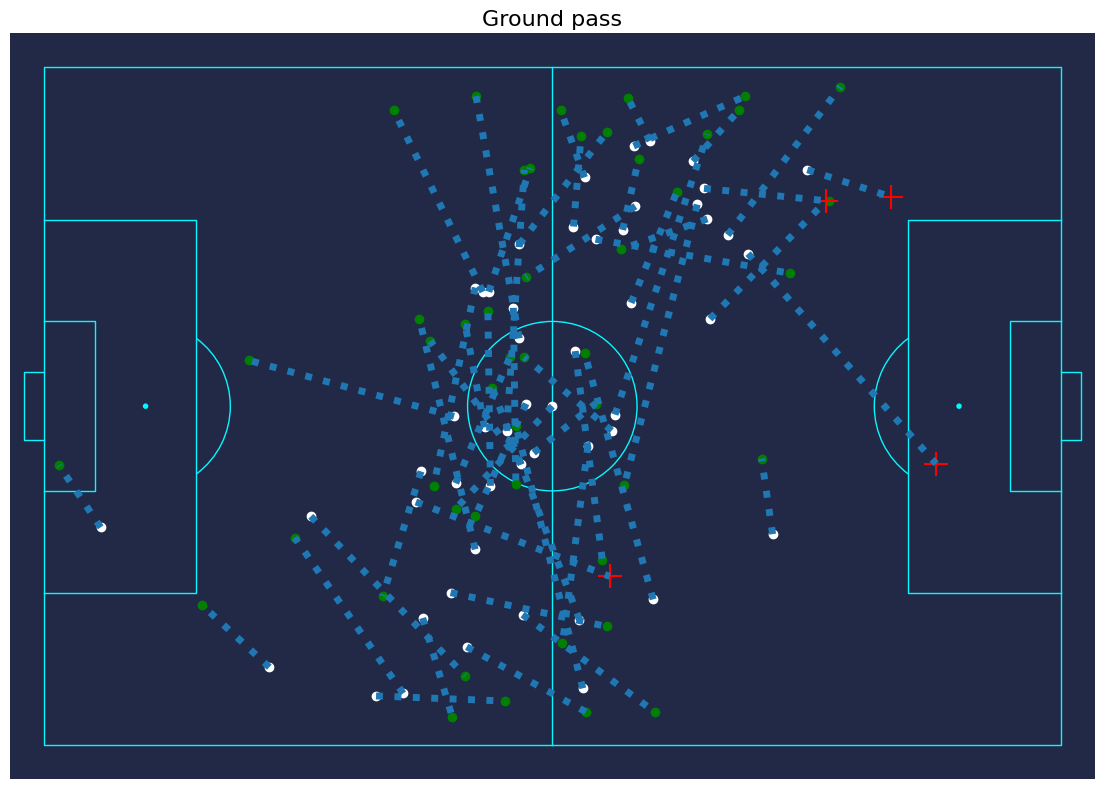

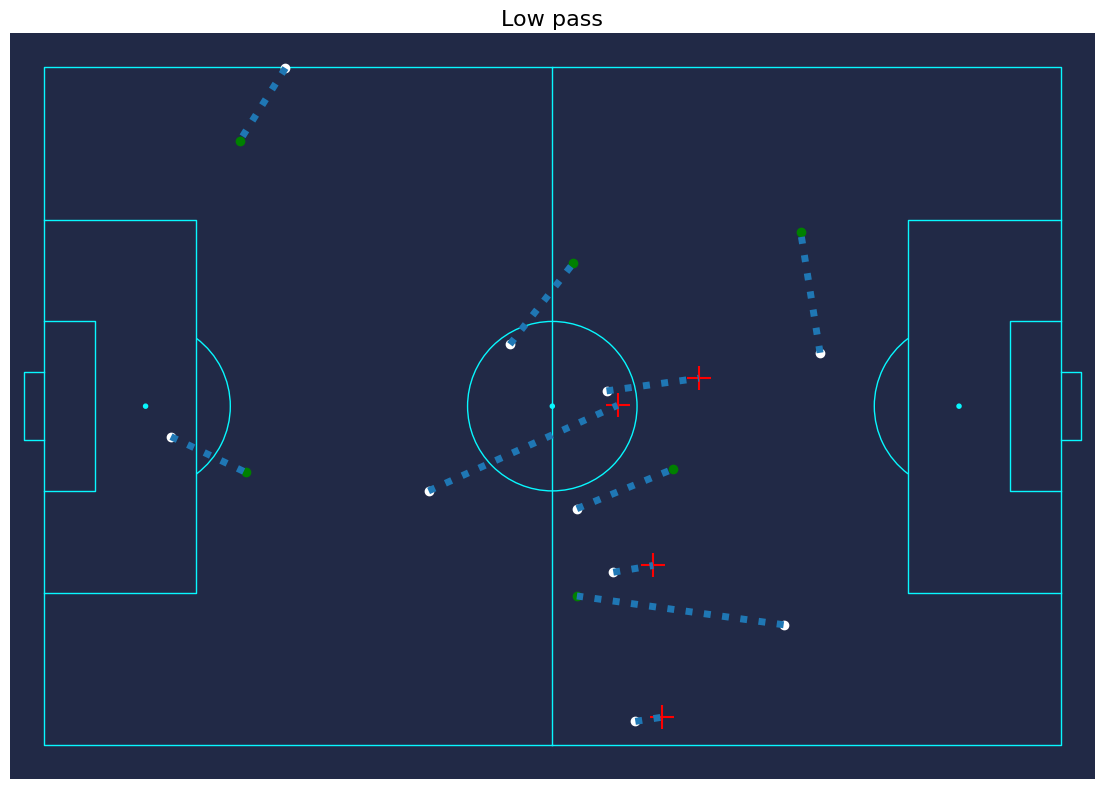

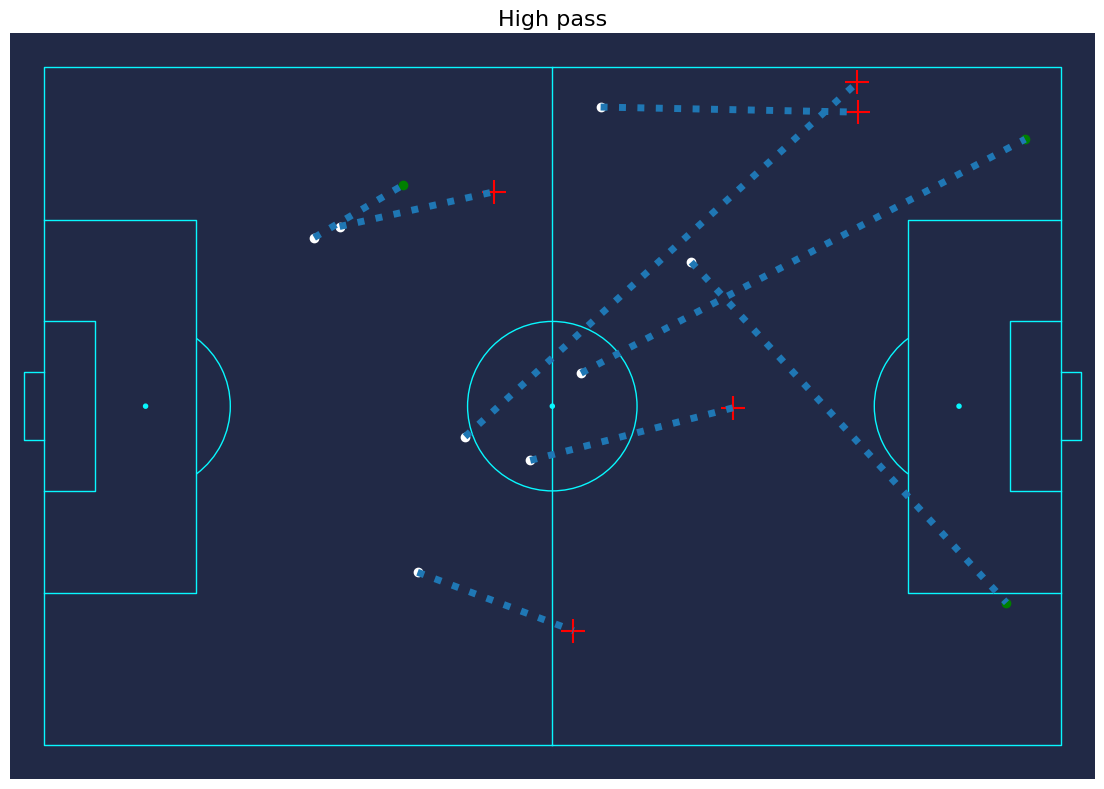

In [7]:
## filtering the dataframe according to the passes which are of three types

df_ground_pass = Tchouaméni_pass[Tchouaméni_pass['pass_height']=="Ground Pass"]
df_low_pass = Tchouaméni_pass[Tchouaméni_pass['pass_height']=="Low Pass"]
df_high_pass = Tchouaméni_pass[Tchouaméni_pass['pass_height']=="High Pass"]

LINEWIDTH = 1  # starting linewidth
DIFF_LINEWIDTH = 1.2  # amount the glow linewidth increases each loop
NUM_GLOW_LINES = 10  # the amount of loops, if you increase the glow will be wider

# in each loop, for the glow, we plot the alpha divided by the num_glow_lines
# I have a lower alpha_pass_line value as there is a slight overlap in
# the pass comet lines when using capstyle='round'
ALPHA_PITCH_LINE = 0.3
ALPHA_PASS_LINE = 0.15

# The colors are borrowed from mplcyberpunk. Try some of the following alternatives
# '#08F7FE' (teal/cyan), '#FE53BB' (pink), '#F5D300' (yellow),
# '#00ff41' (matrix green), 'r' (red), '#9467bd' (viloet)
BACKGROUND_COLOR = '#212946'
PASS_COLOR = '#FE53BB'
LINE_COLOR = '#08F7FE'
p = Pitch(line_color=LINE_COLOR, pitch_color=BACKGROUND_COLOR, linewidth=LINEWIDTH,
              line_alpha=1, goal_alpha=1, goal_type='box')

## plot for ground pass
fig, ax = p.draw(figsize=(12, 8))
ax.set_title("Ground pass", fontsize=16)
for index, row in df_ground_pass.iterrows():
    if row['pass_outcome'] in ['Incomplete', 'Out']:       
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'],s=300, color='red',ax=ax,marker='+')
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted') 
    else:
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'], color='green',ax=ax)
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted')

fig, ax = p.draw(figsize=(12, 8))
ax.set_title("Low pass", fontsize=16)
for index, row in df_low_pass.iterrows():
    if row['pass_outcome'] in ['Incomplete', 'Out']:       
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'],s=300, color='red',ax=ax,marker='+')
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted') 
    else:
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'], color='green',ax=ax)
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted') 

fig, ax = p.draw(figsize=(12, 8))
ax.set_title("High pass", fontsize=16)
for index, row in df_high_pass.iterrows():
    if row['pass_outcome'] in ['Incomplete', 'Out']:      
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'],s=300, color='red',ax=ax,marker='+')
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted') 
    else:
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'], color='green',ax=ax)
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted') 

### Creating a pass HeatMap

In [8]:
## setting the x and y start and end points for the passes
df_pass[['x_start','y_start']] = pd.DataFrame(df_pass.location.tolist(),index=df_pass.index)
df_pass[['x_end','y_end']] = pd.DataFrame(df_pass.pass_end_location.tolist(),index=df_pass.index)
## calculating the distances
df_pass['distance'] = np.sqrt((df_pass['x_end'] - df_pass['x_start'])**2 + (df_pass['y_end'] - df_pass['y_start'])**2)
df_pass.head()

type      location pass_end_location pass_outcome  \
12  Pass  [61.0, 40.1]      [48.0, 43.2]          NaN   
13  Pass  [49.7, 43.6]       [96.0, 1.8]          Out   
28  Pass   [68.5, 5.7]      [72.1, 13.4]          NaN   
29  Pass  [72.3, 13.4]       [73.6, 4.7]          NaN   
30  Pass   [73.2, 4.0]       [47.1, 7.4]      Unknown   

                     pass_recipient pass_type   play_pattern  \
12        Aurélien Djani Tchouaméni  Kick Off  From Kick Off   
13                   Olivier Giroud       NaN  From Kick Off   
28                    Adrien Rabiot       NaN   Regular Play   
29  Theo Bernard François Hernández       NaN   Regular Play   
30                              NaN       NaN   Regular Play   

                             player under_pressure  x_start  y_start  x_end  \
12                Antoine Griezmann            NaN     61.0     40.1   48.0   
13        Aurélien Djani Tchouaméni            NaN     49.7     43.6   96.0   
28  Theo Bernard François Hernández            NaN     68.5      5.7   72.1   
29                    Adrien Rabiot            NaN     72.3     13.4   73.6   
30  Theo Bernard François Hernández           True     73.2      4.0   47.1   

    y_end   distance  
12   43.2  13.364505  
13    1.8  62.377320  
28   13.4   8.500000  
29    4.7   8.796590  
30    7.4  26.320524

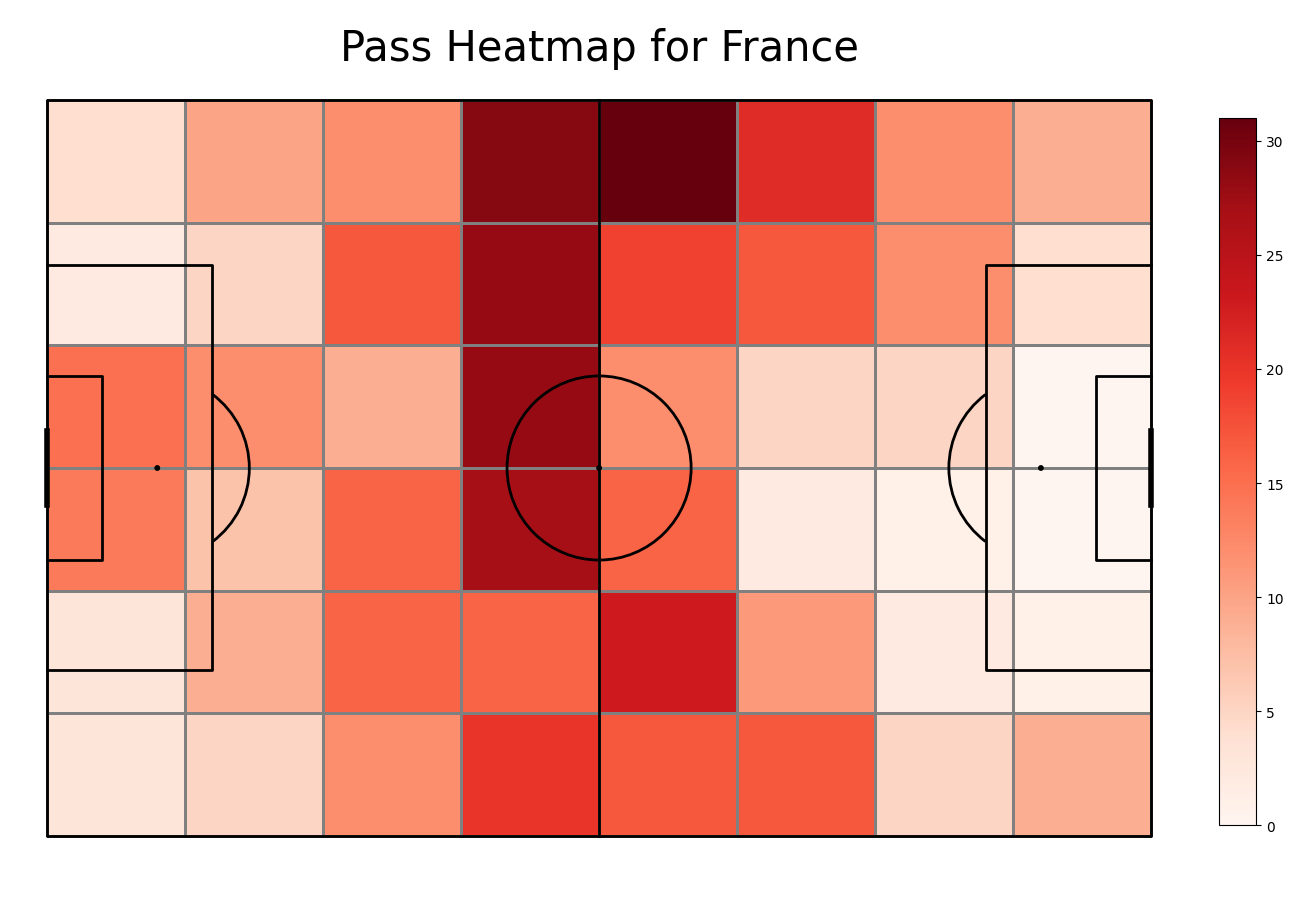

In [9]:
# plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# get the 2D histogram
bin_statistic = pitch.bin_statistic(df_pass.x_start, df_pass.y_start, statistic='count', bins=(8, 6), normalize=False)
pcm = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# add legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Pass Heatmap for France", fontsize=30)
plt.show()

### Creating a passing graph

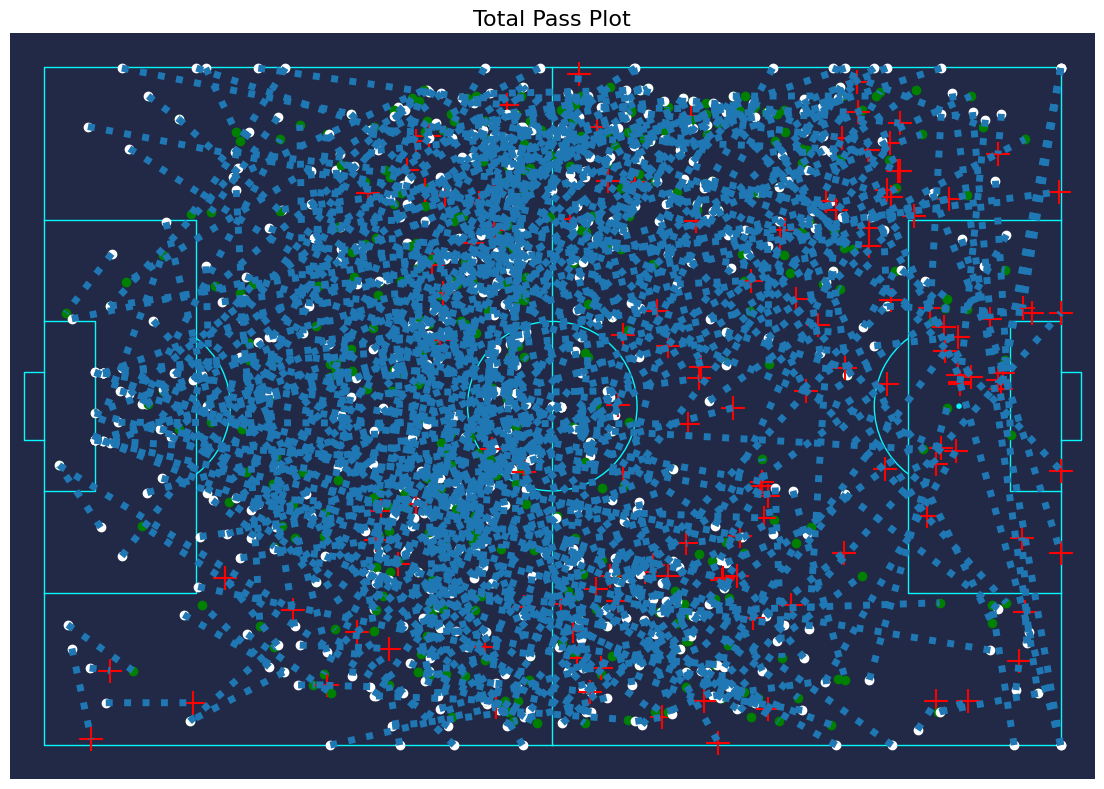

In [10]:
fig, ax = p.draw(figsize=(12, 8))
ax.set_title("Total Pass Plot", fontsize=16)
for index, row in df_pass.iterrows():
    if row['pass_outcome'] in ['Incomplete', 'Out']:       
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'],s=300, color='red',ax=ax,marker='+')
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted') 
    else:
        p.scatter(x=row['x_start'], y=row['y_start'], color='white',ax=ax)
        p.scatter(x=row['x_end'], y=row['y_end'], color='green',ax=ax)
        p.lines(xstart=row['x_start'], xend=row['x_end'], ystart=row['y_start'], yend=row['y_end'], ax=ax,linestyle='dotted')

### Creating a passing Network

In [76]:
pass_recipient_data = df_pass[['player', 'pass_recipient', 'x_start', 'y_start', 'x_end', 'y_end']].reset_index().drop('index', axis=1)
pass_recipient_data['player'] = pass_recipient_data['player'].apply(lambda x: x.split(" ")[1])
pass_recipient_data['pass_recipient'] = pass_recipient_data['pass_recipient'].apply(lambda x: x.split(" ")[1] if not pd.isna(x) else x)
pass_recipient_data.head()

player pass_recipient  x_start  y_start  x_end  y_end
0  Griezmann          Djani     61.0     40.1   48.0   43.2
1      Djani         Giroud     49.7     43.6   96.0    1.8
2    Bernard         Rabiot     68.5      5.7   72.1   13.4
3     Rabiot        Bernard     72.3     13.4   73.6    4.7
4    Bernard            NaN     73.2      4.0   47.1    7.4

### Calculating edges width

In [77]:
lines_df = pass_recipient_data.groupby(['player','pass_recipient']).x_start.count().reset_index()
lines_df.rename({'x_start':'pass_count'},axis='columns',inplace=True)
lines_df = lines_df[lines_df['pass_count']>0]

lines_df.head()

player pass_recipient  pass_count
0  Bernard          Djani           5
1  Bernard         Giroud           1
2  Bernard      Griezmann           4
3  Bernard         Koundé           1
4  Bernard         Lloris           1

### Calculating the vertices size and location

In [78]:
scatter_df = pd.DataFrame()
for i, name in enumerate(pass_reciepient_data["player"].unique()):
    passx = pass_reciepient_data.loc[pass_reciepient_data["player"] == name]["x_start"].to_numpy()
    recx = pass_reciepient_data.loc[pass_reciepient_data["pass_recipient"] == name]["x_end"].to_numpy()
    passy = pass_reciepient_data.loc[pass_reciepient_data["player"] == name]["y_start"].to_numpy()
    recy = pass_reciepient_data.loc[pass_reciepient_data["pass_recipient"] == name]["y_end"].to_numpy()
    scatter_df.at[i, "player"] = name
    # make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    # calculate number of passes
    scatter_df.at[i, "no"] = pass_reciepient_data.loc[pass_reciepient_data["player"] == name].shape[0]
# adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [79]:
scatter_df.head()

player          x          y    no  marker_size
0  Griezmann  72.910000  40.170000  30.0   652.173913
1      Djani  58.489855  39.128986  69.0  1500.000000
2    Bernard  62.904082   6.136735  49.0  1065.217391
3     Rabiot  64.609804  26.709804  51.0  1108.695652
4     Varane  45.170492  51.096721  61.0  1326.086957

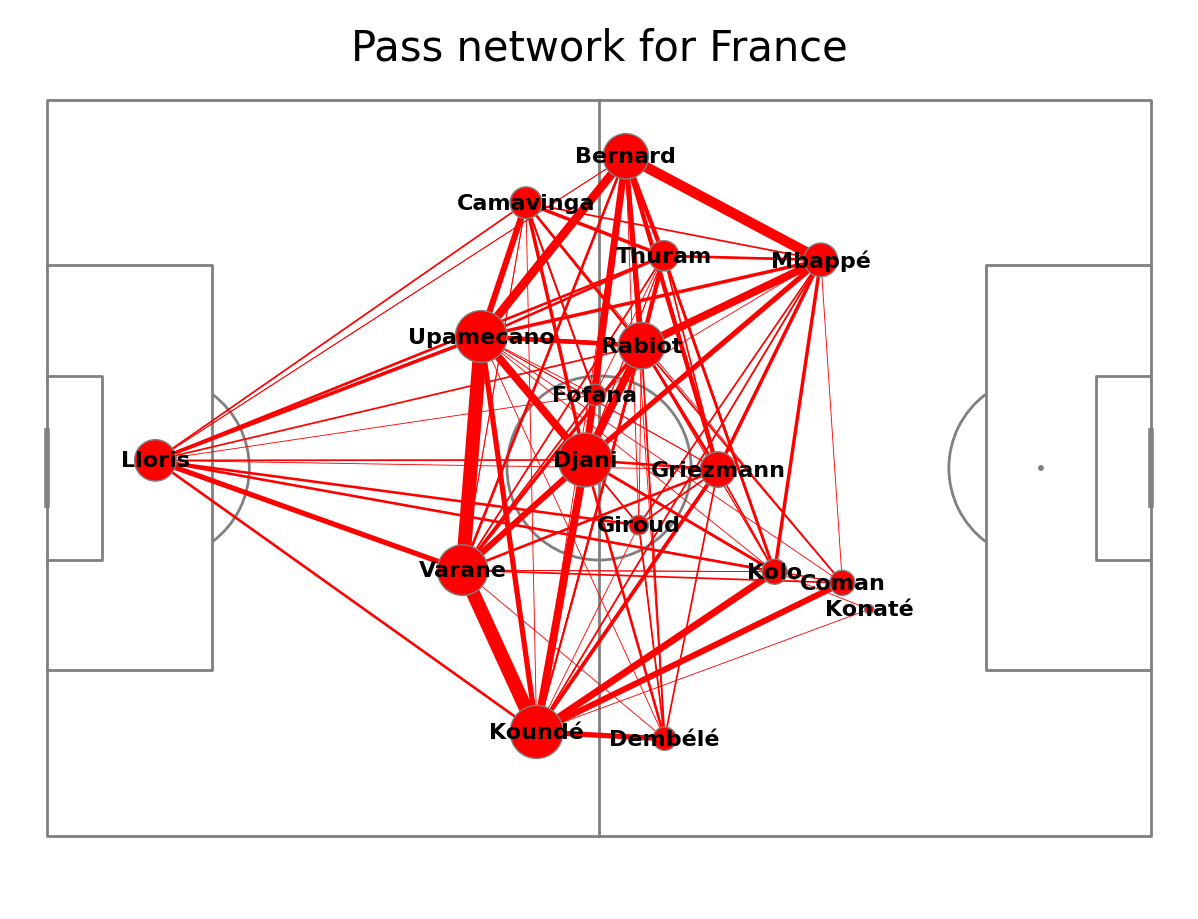

In [85]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
    player1 = row['player']
    player2 = row['pass_recipient']
    #take the average location of players to plot a line between them
    player1_x = scatter_df.loc[scatter_df["player"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["player"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]
    #adjust the line width so that the more passes, the wider the line
    line_width = (num_passes / lines_df['pass_count'].max() * 10)
    #plot lines on the pitch
    pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("Pass network for France", fontsize = 30)
plt.show()